## Part II: Feature Selection and Data Cleansing

#### Setup Environment

In [1]:
%run environment-setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [48]:
# import additional libs
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from scipy.stats import pointbiserialr

In [2]:
# Create database in Athena/Glue
wr.catalog.create_database(database_name)

In [4]:
# read from datalake (S3)
sepsis_df = wr.s3.read_csv(s3_datalake_path_csv + "/dataset.csv")
sepsis_ts_stats = wr.s3.read_csv(s3_datalake_path_csv + "/patient_ts_stats.csv")

### Feature Selection: Evaluate Feature Importance and Conduct Feature Selection on the Data

Based on EDA and domain expertise in the medical field, the features will be narrowed down to those deemed to those that are likely to influence Sepsis outcomes. 

 To support this selection, first a simple decision tree model will be trained on a summary of the dataset and feature importance will be evaluated.  In addition, a Point-biserial correlation coefficient (PBC) will be calculated for each continuous feature vs. our binary class.

In [19]:
# roll up the dataset to patien level, using avg value for each feature 
sepsis_patient_summary = sepsis_df.groupby(['Patient_ID']).mean()
sepsis_patient_summary.fillna(0, inplace=True)
sepsis_patient_summary = sepsis_patient_summary.drop(columns=['Unnamed: 0'])
sepsis_patient_summary = sepsis_patient_summary.reset_index()
sepsis_patient_summary['SepsisLabel'] = sepsis_patient_summary['SepsisLabel'].astype(int)
sepsis_patient_summary

,Patient_ID,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,1,26.5,101.571429,91.477273,36.778000,126.809524,87.261905,0.000000,24.820000,0.0,...,10.200000,0.0,327.500000,83.14,0.0,0.0,0.0,-0.03,27.5,0
1,2,11.0,60.954545,97.000000,36.165000,136.600000,66.704545,44.066667,14.236842,0.0,...,11.000000,0.0,158.000000,75.91,0.0,0.0,1.0,-98.60,12.0,0
2,3,23.5,79.611111,95.431818,37.609375,140.033333,81.048000,54.392857,25.633333,0.0,...,9.000000,0.0,479.666667,45.82,0.0,1.0,0.0,-1195.71,24.5,0
3,4,14.0,102.444444,98.203704,36.455000,113.019231,67.147308,51.428571,18.884615,0.0,...,7.600000,0.0,182.000000,65.71,0.0,0.0,1.0,-8.77,15.0,0
4,5,23.5,73.916667,97.500000,36.992222,132.770833,87.088235,0.000000,16.500000,0.0,...,6.933333,0.0,279.000000,28.09,1.0,1.0,0.0,-0.05,25.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40331,119996,23.5,89.456522,98.086957,36.400000,131.366667,84.602273,71.922222,19.176471,0.0,...,12.600000,0.0,238.000000,84.00,0.0,0.0,0.0,-6.69,24.5,0
40332,119997,12.0,61.062500,96.833333,36.800000,119.562500,90.937500,70.250000,20.384615,45.0,...,10.400000,0.0,189.000000,30.00,1.0,0.0,0.0,-0.02,13.0,0
40333,119998,24.0,80.202381,96.255814,36.733333,157.526316,116.157895,88.644737,20.578947,0.0,...,12.266667,0.0,197.333333,60.00,0.0,1.0,0.0,-53.64,25.0,0
40334,119999,9.5,94.333333,92.722222,37.620000,141.722222,100.833333,74.416667,21.666667,0.0,...,10.700000,0.0,263.500000,84.00,0.0,1.0,0.0,-10.74,10.5,0


In [53]:
# list all columns so we can evaluate what to include
cols = sepsis_patient_summary.columns.to_list()
for idx, col in enumerate(cols):
    print(f"{idx}: {col}")

0: Patient_ID
1: Hour
2: HR
3: O2Sat
4: Temp
5: SBP
6: MAP
7: DBP
8: Resp
9: EtCO2
10: BaseExcess
11: HCO3
12: FiO2
13: pH
14: PaCO2
15: SaO2
16: AST
17: BUN
18: Alkalinephos
19: Calcium
20: Chloride
21: Creatinine
22: Bilirubin_direct
23: Glucose
24: Lactate
25: Magnesium
26: Phosphate
27: Potassium
28: Bilirubin_total
29: TroponinI
30: Hct
31: Hgb
32: PTT
33: WBC
34: Fibrinogen
35: Platelets
36: Age
37: Gender
38: Unit1
39: Unit2
40: HospAdmTime
41: ICULOS
42: SepsisLabel


In [43]:
# separate input features from target - drop features that are time-series specfic from input
X_dt = sepsis_patient_summary.drop(columns=['SepsisLabel', 'Hour', 'ICULOS', 'HospAdmTime'])
y_dt = sepsis_patient_summary['SepsisLabel']

In [44]:
# do some simple balancing of the target class
rus = RandomUnderSampler(random_state=42)
X_dt_resampled, y_dt_resampled = rus.fit_resample(X_dt, y_dt)

In [45]:
# Check class distribution after resampling
print('Resampled dataset shape %s' % Counter(y_dt_resampled))

Resampled dataset shape Counter({0: 426, 1: 426})


In [46]:
# Create a decision tree classifier
dt_clf = DecisionTreeClassifier()

# Fit the classifier to the data
dt_clf.fit(X_dt_resampled, y_dt_resampled)

# Access the feature importances
feature_importances = dt_clf.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_dt.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print(feature_importance_df)

             Feature  Importance
34         Platelets    0.144052
3               Temp    0.134774
32               WBC    0.076016
20        Creatinine    0.074269
2              O2Sat    0.073672
1                 HR    0.053542
22           Glucose    0.042303
4                SBP    0.040822
16               BUN    0.034325
35               Age    0.033170
0         Patient_ID    0.032187
6                DBP    0.026499
29               Hct    0.024699
27   Bilirubin_total    0.023470
19          Chloride    0.018222
24         Magnesium    0.016756
37             Unit1    0.016559
23           Lactate    0.016246
26         Potassium    0.014132
5                MAP    0.013677
14              SaO2    0.012383
13             PaCO2    0.010972
15               AST    0.010808
28         TroponinI    0.008477
7               Resp    0.007782
31               PTT    0.007578
25         Phosphate    0.007512
10              HCO3    0.007147
8              EtCO2    0.004448
18        

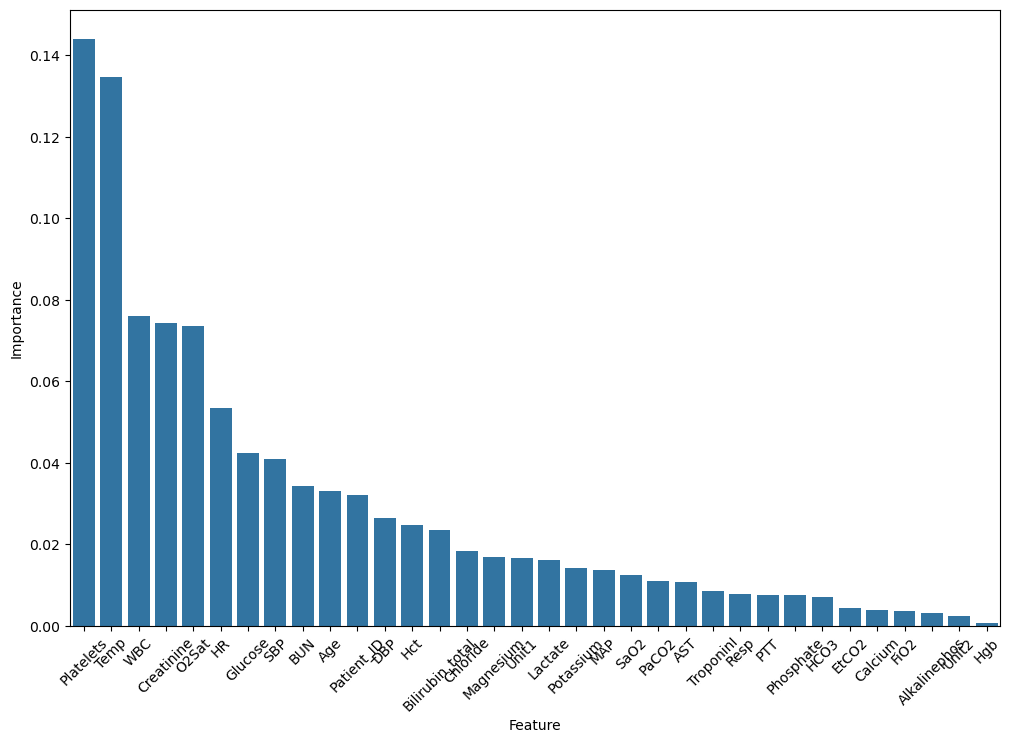

In [47]:
# plot the feature importance
important_features = feature_importance_df[feature_importance_df['Importance'] > 0]
plt.figure(figsize=(12,8))
sns.barplot(x=important_features['Feature'], y=important_features['Importance'])
plt.xticks(rotation=45)
plt.show()

#### Calculate Point-biserial correlation coefficient (PBC) for each continuous feature

In [57]:
# get the continuous columns
pbc_coefficients = []
sepsis_cont_vars = sepsis_patient_summary.iloc[:, 2:36]
sepsis_target = sepsis_patient_summary['SepsisLabel']
for idx, col in enumerate(sepsis_cont_vars.columns.to_list()):
    r_pb, p_value = pointbiserialr(sepsis_target, sepsis_cont_vars.iloc[:, idx])
    pbc_coefficients.append([col, r_pb, p_value])

pbc_coefficients_df = pd.DataFrame(data=pbc_coefficients, columns=['feature', 'pb', 'p_value'])

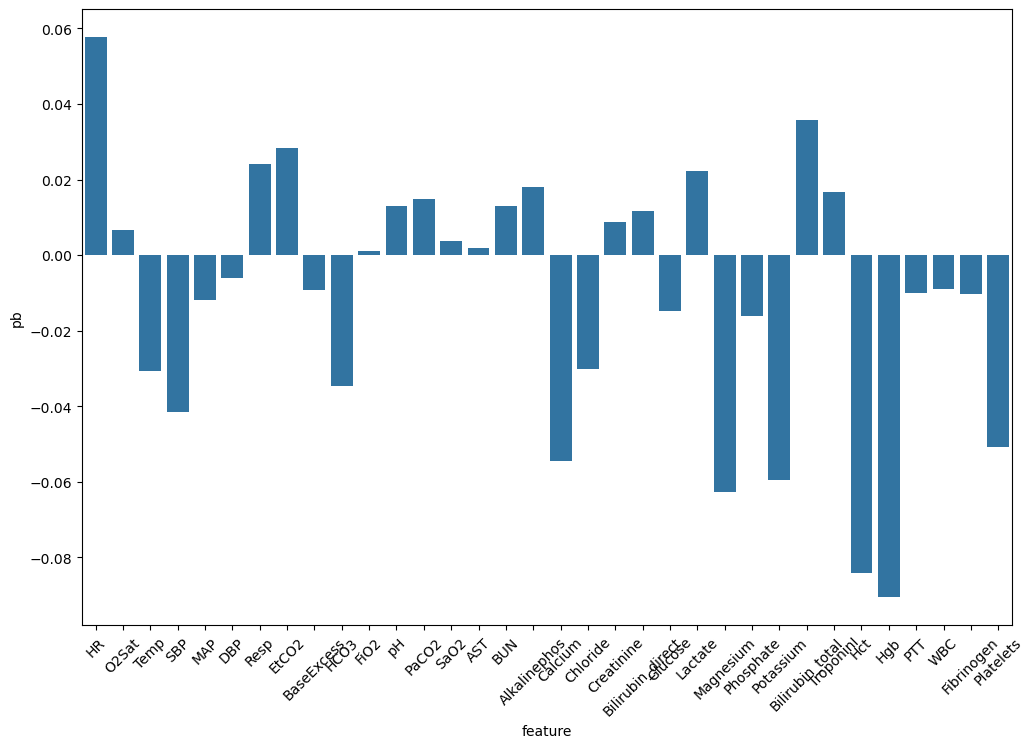

In [58]:
# plot the pbc
important_features = feature_importance_df[feature_importance_df['Importance'] > 0]
plt.figure(figsize=(12,8))
sns.barplot(x=pbc_coefficients_df['feature'], y=pbc_coefficients_df['pb'])
plt.xticks(rotation=45)
plt.show()